In [20]:
from google.colab import files
uploaded = files.upload()  # This will allow you to select images from your local machine

# Check if images are uploaded correctly
print(uploaded.keys())


Saving signature (8).jpg to signature (8) (2).jpg
dict_keys(['signature (8) (2).jpg'])


In [21]:
import shutil
import os

# Create directories to organize images
image_dir = '/content/unorganized_images'
genuine_dir = '/content/signature_data/genuine'
forged_dir = '/content/signature_data/forged'

os.makedirs(genuine_dir, exist_ok=True)
os.makedirs(forged_dir, exist_ok=True)

# Move the images to their respective folders based on their filename
for filename in uploaded.keys():
    if 'genuine' in filename.lower():
        shutil.move(filename, os.path.join(genuine_dir, filename))
    elif 'forged' in filename.lower():
        shutil.move(filename, os.path.join(forged_dir, filename))

# Verify that the files are correctly moved
print("Genuine files:", os.listdir(genuine_dir))
print("Forged files:", os.listdir(forged_dir))


Genuine files: ['signature (18).jpg', 'signature (10).jpg', 'signature (13).jpg', 'signature (2).jpg', 'signature (20).jpg', 'signature (15).jpg', 'signature (19).jpg', 'signature (11).jpg']
Forged files: ['signature (14).jpg', 'signature (17).jpg', 'signature (12).jpg', 'signature (16).jpg']


In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize ImageDataGenerator for real-time data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Normalize pixel values to [0, 1]
    rotation_range=40,     # Random rotations
    width_shift_range=0.2, # Random horizontal shift
    height_shift_range=0.2,# Random vertical shift
    shear_range=0.2,       # Shearing transformation
    zoom_range=0.2,        # Zooming
    horizontal_flip=True,  # Flip images randomly
    fill_mode='nearest'    # Filling missing pixels after transformations
)

# Setup flow_from_directory to load images from the directory
train_generator = train_datagen.flow_from_directory(
    '/content/signature_data',  # Directory where images are stored
    target_size=(224, 224),     # Resize images to a consistent size
    batch_size=32,              # Number of images per batch
    class_mode='binary'         # Binary classification (genuine vs. forged)
)

# Check if images are being loaded properly
print(f"Classes: {train_generator.class_indices}")


Found 12 images belonging to 2 classes.
Classes: {'forged': 0, 'genuine': 1}


In [23]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the pre-trained ResNet50 model (without the top layer)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model (so we don't retrain them)
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Apply global average pooling to reduce feature dimensions
x = Dense(1024, activation='relu')(x)  # Fully connected layer
predictions = Dense(1, activation='sigmoid')(x)  # Sigmoid activation for binary classification

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 25,686,913 (97.99 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [24]:
# Train the model with the data generator
history = model.fit(
    train_generator,
    steps_per_epoch=100,   # Number of batches per epoch
    epochs=10,             # Number of training epochs
    verbose=1              # Display training progress
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 394us/step - accuracy: 0.6667 - loss: 0.6568
Epoch 2/10


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 145us/step - accuracy: 0.6667 - loss: 0.6391
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 182us/step - accuracy: 0.6667 - loss: 0.6370
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 142us/step - accuracy: 0.6667 - loss: 0.6398
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 142us/step - accuracy: 0.6667 - loss: 0.6360
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 136us/step - accuracy: 0.6667 - loss: 0.6300
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 136us/step - accuracy: 0.6667 - loss: 0.6273
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 196us/step - accuracy: 0.6667 - loss: 0.6118
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 145us/step - accuracy: 0.6667 - loss: 0.6371
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 143us/step - accuracy: 0.6667 - loss: 0.6150


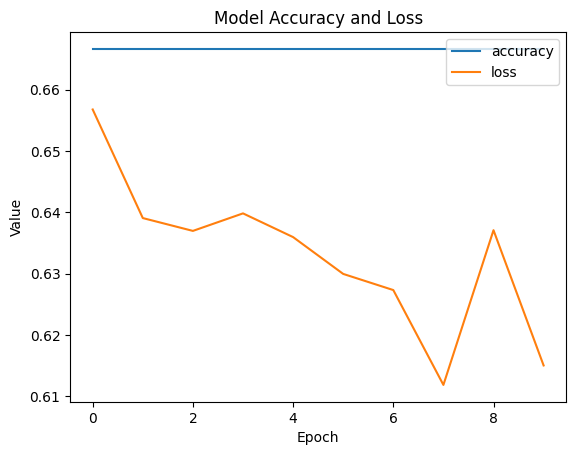

In [25]:
import matplotlib.pyplot as plt  # Importing the plotting library

# Now you can plot the graph
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label='loss')
plt.title('Model Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(loc='upper right')
plt.show()


In [26]:
# Save the model to a file
model.save('/content/signature_model.h5')  # .h5 is the file extension for Keras models



In [27]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('/content/signature_model.h5')
